In [114]:
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RepeatedKFold
import sklearn.metrics as sklm
import numpy as np
import sklearn.model_selection as le_ms
import sklearn.preprocessing as skpp
import xgboost as xgb
#from sklearn.linear_model import RidgeClassifier
import sklearn.utils as sklu
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, accuracy_score, mean_squared_error
import seaborn as sns

In [5]:
df = pd.read_csv("/Users/cartersilos/Downloads/DATASET_clean.csv")

In [7]:
df.columns

Index(['SEQN', 'a1c_test', 'DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TSUGR',
       'DR1TFIBE', 'DR1TTFAT', 'DR1TSFAT', 'DR1TMFAT', 'DR1TPFAT', 'DR1TCHOL',
       'DR1TVB12', 'DR1TVC', 'DR1TMAGN', 'DR1TCAFF', 'DR1TSODI', 'DR1TALCO',
       'DR1_320Z', 'DMDBORN', 'RIDRETH', 'RIAGENDR', 'DMDEDUC', 'DMDMARTX',
       'INDFMPIR', 'BPXOSY', 'BPXODI', 'BMXBMI', 'BMXWAIST', 'ALQ111',
       'PAD680', 'PAD790Q', 'SMQ020', 'SLD012', 'DPQ010', 'DPQ040', 'DPQ050',
       'DPQ060'],
      dtype='object')

In [11]:
X = df.drop(columns= ['a1c_test']).copy() # make a copy of only the x variables
y = df['a1c_test'] # isolate the outcome (y variable)

In [15]:
X_train, X_test, y_train, y_test = le_ms.train_test_split(X, y, random_state=12345, train_size=0.8, stratify = y)

columns = X_train.columns

In [18]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
import hyperopt.hp as hpo 

In [20]:
N_SPLITS = 10
kfold = le_ms.StratifiedKFold(n_splits = N_SPLITS)


In [22]:
# set the parameter space and values for the algorithm to search through
space = {'max_depth': hp.quniform("max_depth", 1, 20, 1),
            'gamma': hp.uniform('gamma', 0,25),
            'reg_alpha': hp.quniform('reg_alpha', 0, 100, 1),
            'reg_lambda': hp.uniform('reg_lambda', 0,250),
            'colsample_bytree': hp.uniform('colsample_bytree', 0,1),
            'min_child_weight': hp.quniform('min_child_weight', 0, 200, 1),
            'n_estimators': 180,
            'eval_metric': 'auc',
            'random_state': [1234],
            'early_stopping': 50,
         'scale_pos_weight': hp.quniform('scale_pos_weight', 0, 200, 1)
}

In [24]:
def hyperparameter_tuning(space):
    #classes_weights = sklu.class_weight.compute_sample_weight(
    #class_weight='balanced',
    #y=trainY)
    model = xgb.XGBClassifier(#n_estimators =space['n_estimators'],
                                max_depth = int(space['max_depth']), gamma = space['gamma'],
                                reg_alpha = int(space['reg_alpha']), min_child_weight=space['min_child_weight'],
                                colsample_bytree = space['colsample_bytree'], eval_metric = 'auc',scale_pos_weight=int(space['scale_pos_weight']),
        
        
        n_jobs=-1)
   


    model.fit(trainX, trainY, verbose=False)

    #pred = model.predict(testX)
    y_pred = model.predict_proba(testX)
    y_true = np.array(testY)
    y_scores = y_pred[:, 1]

    fpr, tpr, _ = sklm.roc_curve(testY, y_scores)
    #AUC = sklm.roc_auc_score(testY, pred)
    roc_auc = sklm.auc(fpr, tpr)
    #print(roc_auc)
    
    return {'loss':-roc_auc, 'status': STATUS_OK, 'model': model}

In [26]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

In [28]:
## Cross validation
max_depth_list = []
auc_list = []
gamma_list = []
reg_alpha_list = []
reg_lambda_list = []
col_sample_by_tree_list = []
min_child_weight_list = []
scale_pos_weight_list = []
np.random.seed(1234567)
for train_index, test_index in kfold.split(range(len(y_train)), y = y_train):
    
    # split labels and feature matrix
    trainX = X_train[train_index]
    trainY = y_train[train_index]
    testX = X_train[test_index]
    testY = y_train[test_index]
    rstate = np.random.default_rng(1234) # note that you must set this so that the fmin is reproducible
    # run the algorithm
    #scaler = skpp.MinMaxScaler()
    #scaler.fit(trainX)
    #trainX = scaler.transform(trainX)
    #testX = scaler.transform(testX)
    trials = Trials()
    best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=200,
            trials=trials,
            rstate=rstate)

    print(best) # print the best parameter values
    # extract the best model
    best_loss = trials.best_trial['result']['loss'] 
    print(best_loss)

    auc_list.append(best_loss)
    max_depth_list.append(best['max_depth'])
    gamma_list.append(best['gamma'])
    reg_alpha_list.append(best['reg_alpha'])
    reg_lambda_list.append(best['reg_lambda'])
    col_sample_by_tree_list.append(best['colsample_bytree'])
    min_child_weight_list.append(best['min_child_weight'])
    scale_pos_weight_list.append(best['scale_pos_weight'])

100%|██████████████████| 200/200 [00:22<00:00,  8.74trial/s, best loss: -0.7835]
{'colsample_bytree': 0.15601415995114432, 'gamma': 7.4699968334799225, 'max_depth': 9.0, 'min_child_weight': 159.0, 'reg_alpha': 11.0, 'reg_lambda': 55.89047856465791, 'scale_pos_weight': 145.0}
-0.7835
100%|██████| 200/200 [00:22<00:00,  9.09trial/s, best loss: -0.7844374999999999]
{'colsample_bytree': 0.8004989443760937, 'gamma': 19.210202697428798, 'max_depth': 19.0, 'min_child_weight': 181.0, 'reg_alpha': 61.0, 'reg_lambda': 70.04359442910695, 'scale_pos_weight': 57.0}
-0.7844374999999999
100%|██████| 200/200 [00:19<00:00, 10.31trial/s, best loss: -0.7979999999999999]
{'colsample_bytree': 0.05912591171858019, 'gamma': 15.806556617521377, 'max_depth': 9.0, 'min_child_weight': 79.0, 'reg_alpha': 29.0, 'reg_lambda': 79.97201845175988, 'scale_pos_weight': 87.0}
-0.7979999999999999
100%|████████████████| 200/200 [00:21<00:00,  9.48trial/s, best loss: -0.842375]
{'colsample_bytree': 0.157418382676196, 'gamma

In [30]:
## Cross Validation
test_set_auc = []
np.random.seed(123456)
for i in range(0, 10, 1):
    print(i)
    model = xgb.XGBClassifier(
                                max_depth = int(max_depth_list[i]), gamma = gamma_list[i],
                                reg_alpha = int(reg_alpha_list[i]), min_child_weight=min_child_weight_list[i], reg_lambda = reg_lambda_list[i],
                                colsample_bytree = col_sample_by_tree_list[i], eval_metric = 'auc',scale_pos_weight = int(scale_pos_weight_list[i]), n_jobs=-1)


    model.fit(X_train, y_train, verbose=False)

    y_pred = model.predict_proba(X_test)
    y_true = np.array(y_test)
    y_scores = y_pred[:, 1]

    fpr, tpr, _ = sklm.roc_curve(y_test, y_scores)
    #AUC = sklm.roc_auc_score(testY, pred)
    roc_auc = sklm.auc(fpr, tpr)
    print(roc_auc)
    test_set_auc.append(roc_auc)

0
0.7621394230769231
1
0.7750000000000001
2
0.7609374999999999
3
0.7826322115384615
4
0.775761217948718
5
0.769891826923077
6
0.7787660256410257
7
0.7784054487179487
8
0.7690104166666667
9
0.7737880608974359


In [32]:
print("Maximum AUC position: ",test_set_auc.index(max(test_set_auc)) )

Maximum AUC position:  3


In [34]:
## Selects best model ran
i = test_set_auc.index(max(test_set_auc))#best i

In [36]:
## Model after cross validation
np.random.seed(1234567)
model = xgb.XGBClassifier(
                                max_depth = int(max_depth_list[i]), gamma = gamma_list[i],
                                reg_alpha = int(reg_alpha_list[i]), min_child_weight=min_child_weight_list[i], reg_lambda = reg_lambda_list[i],
                                colsample_bytree = col_sample_by_tree_list[i], eval_metric = 'auc',scale_pos_weight = int(scale_pos_weight_list[i]), n_jobs=-1)


model.fit(X_train, y_train, verbose=False)

y_pred = model.predict_proba(X_test)
y_true = np.array(y_test)
y_scores = y_pred[:, 1]

fpr, tpr, _ = sklm.roc_curve(y_test, y_scores)
roc_auc = sklm.auc(fpr, tpr)
print(roc_auc)

0.7826322115384615


In [122]:
## MSE, Recall, Precision, and Accuracy
# Convert probabilities to class labels
y_pred_class = (y_scores >= 0.5).astype(int)

# Now calculate metrics using binary predictions
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
accuracy = accuracy_score(y_test, y_pred_class)
mse_prob = mean_squared_error(y_test, y_pred1)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"Accuracy:  {accuracy:.4f}")
print(f"MSE (probabilities): {mse_prob:.4f}")

Precision: 0.1236
Recall:    0.9875
Accuracy:  0.2031
MSE (probabilities): 0.7969


In [54]:
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [60]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba) 
roc_auc = auc(fpr, tpr)

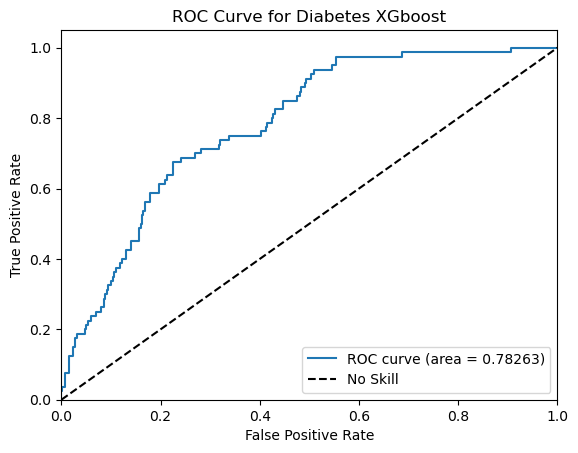

In [68]:
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Diabetes XGboost')
plt.legend()
plt.show()


In [86]:
import shap ## For SHAP plot and values

In [90]:
pred = model.predict(X_test, output_margin=True)

explainer = shap.TreeExplainer(model)
explanation = explainer(X_test)

shap_values = explanation.values
# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max()

1.4305115e-06

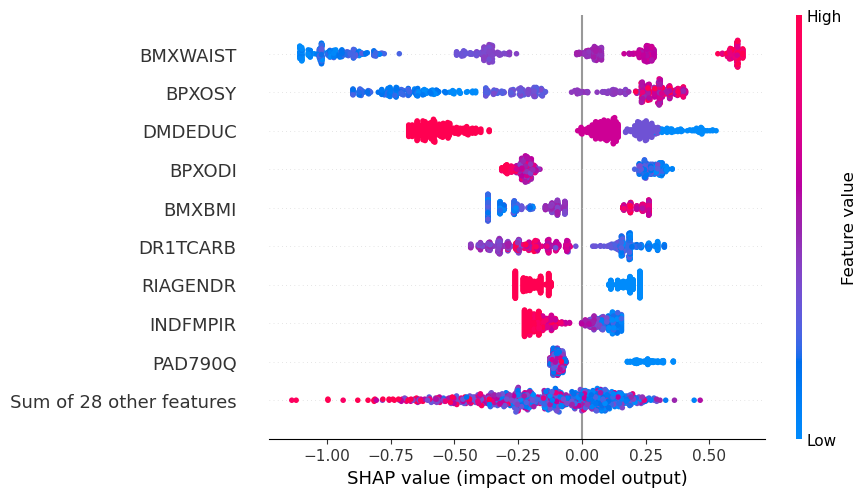

In [94]:
shap.plots.beeswarm(explanation)
## Alligns with diabetes research that as waist circumfrence decreases the risk of diabetes decreases
## Gender our 0 value is more likely to have diabetes and our 1 value is less likely